In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
RANDOM_SEED = 42
os.environ["TF_USE_LEGACY_KERAS"] = "1"


In [2]:

gpus = tf.config.experimental.list_physical_devices('GPU')  #查看


gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Specify each path

In [4]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [6]:
NUM_CLASSES = 36

# Dataset reading

In [8]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [9]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [13]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 64)                2752      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [14]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [15]:
# Learning rate scheduler callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)


In [16]:
# Model compilation with custom JSD loss
# model.compile(
#     optimizer='adam',
#     loss='kullback_leibler_divergence',
#     metrics=['accuracy']
# )

In [17]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [19]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback, lr_callback]
)

Epoch 1/1000
15/20 [=====================>........] - ETA: 0s - loss: 4.9121 - accuracy: 0.0333 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
20/20 [==============================] - 1s 15ms/step - loss: 4.8584 - accuracy: 0.0380 - val_loss: 4.6324 - val_accuracy: 0.1068 - lr: 0.0010
Epoch 2/1000
17/20 [========================>.....] - ETA: 0s - loss: 4.5641 - accuracy: 0.0717
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
20/20 [==============================] - 0s 7ms/step - loss: 4.5471 - accuracy: 0.0696 - val_loss: 4.5283 - val_accuracy: 0.1447 - lr: 0.0010
Epoch 3/1000
16/20 [=======================>......] - ETA: 0s - loss: 4.3644 - accuracy: 0.0952
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
20/20 [==============================] - 0s 8ms/step - loss: 4.3365 - accuracy: 0.1068 - val_loss: 4.3922 - val_accuracy: 0.1922 - lr: 0.0010
Epoch 4/1000
16/20 [=======================>......] -

In [21]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

7/7 [==============================] - 0s 6ms/step - loss: 0.4766 - accuracy: 0.8980


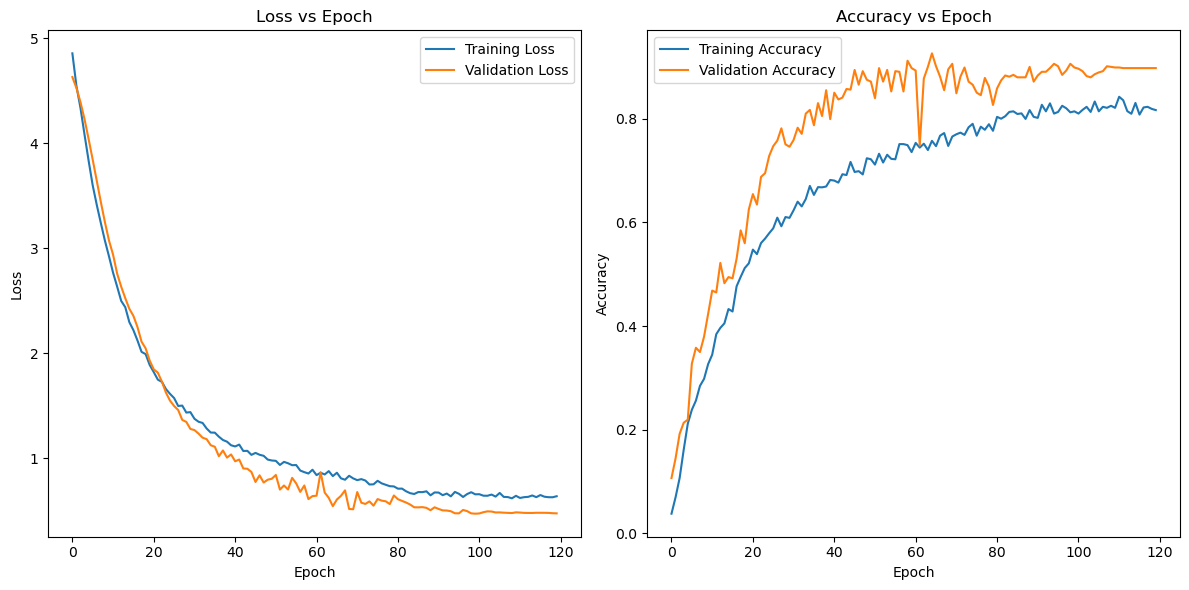

In [28]:
import matplotlib.pyplot as plt
# Plotting loss vs epoch
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

# Plotting accuracy vs epoch
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [36]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 234ms/step
[9.9640992e-04 2.4263210e-04 6.8116252e-04 9.8762906e-04 6.9456808e-05
 2.4297202e-02 4.9521470e-05 1.5139796e-05 1.0275487e-03 2.9102815e-05
 1.8805795e-04 1.3941291e-02 2.8725185e-07 1.7514658e-06 1.5461224e-05
 1.4691425e-05 2.3080269e-04 2.7666636e-05 4.4620632e-05 2.2869937e-05
 5.5129825e-05 6.7488392e-05 3.5742682e-04 7.8475605e-05 3.2541162e-04
 1.2147858e-05 2.8179829e-05 7.2030402e-06 5.2464989e-06 7.1171394e-06
 7.8338944e-06 9.7736720e-06 8.5224883e-06 6.5556223e-06 1.3504270e-05
 9.5612669e-01]
35


# Confusion matrix

27/27 [==============================] - 0s 4ms/step


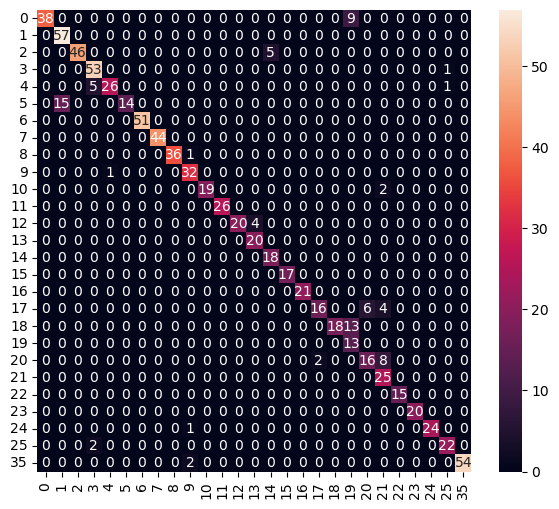

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.89        47
           1       0.79      1.00      0.88        57
           2       1.00      0.90      0.95        51
           3       0.88      0.98      0.93        54
           4       0.96      0.81      0.88        32
           5       1.00      0.48      0.65        29
           6       1.00      1.00      1.00        51
           7       1.00      1.00      1.00        44
           8       1.00      0.97      0.99        37
           9       0.89      0.97      0.93        33
          10       1.00      0.90      0.95        21
          11       1.00      1.00      1.00        26
          12       1.00      0.83      0.91        24
          13       0.83      1.00      0.91        20
          14       0.78      1.00      0.88        18
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00        21
     

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

Epoch 1/1000
20/20 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.7999
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
20/20 [==============================] - 2s 43ms/step - loss: 0.7032 - accuracy: 0.7999 - val_loss: 0.5063 - val_accuracy: 0.8968 - lr: 1.0000e-04
Epoch 2/1000
20/20 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.8090
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
20/20 [==============================] - 0s 22ms/step - loss: 0.6891 - accuracy: 0.8090 - val_loss: 0.5263 - val_accuracy: 0.8932 - lr: 1.0000e-04
Epoch 3/1000
19/20 [===========================>..] - ETA: 0s - loss: 0.6818 - accuracy: 0.8154
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
20/20 [==============================] - 0s 21ms/step - loss: 0.6811 - accuracy: 0.8146 - val_loss: 0.4952 - val_accuracy: 0.9015 - lr: 1.0000e-04
Epoch 4/1000
20/20 [====================

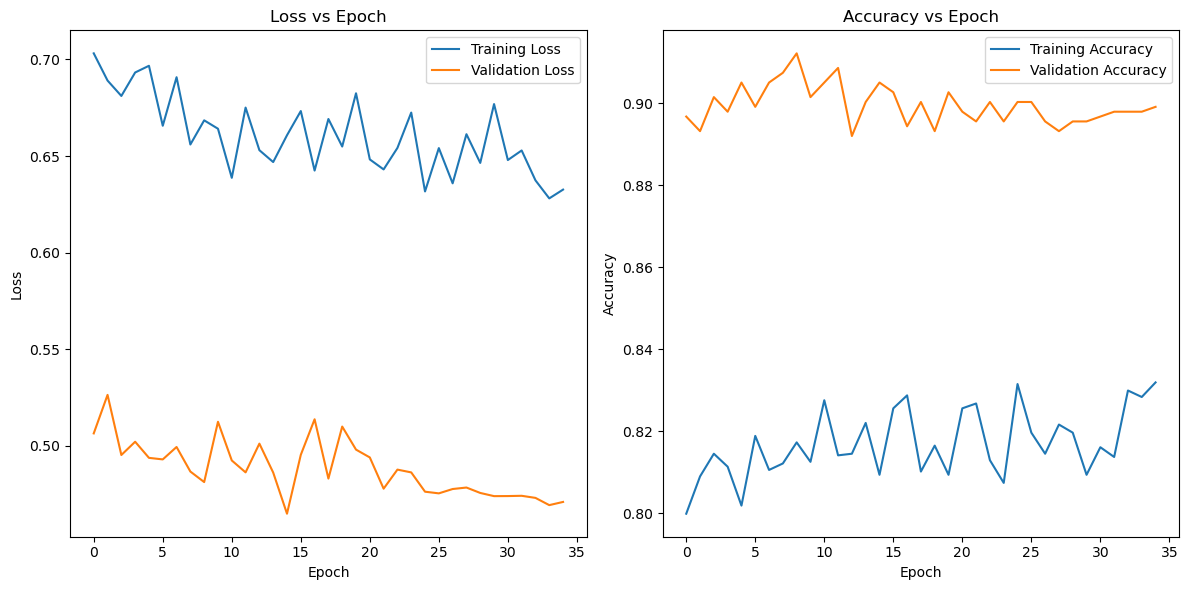

In [61]:
import matplotlib.pyplot as plt

# Training the model and saving the history
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback, lr_callback]
)

# Plotting loss vs epoch
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

# Plotting accuracy vs epoch
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# Convert to model for Tensorflow-Lite

In [46]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [48]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\kuotz\AppData\Local\Temp\tmpsqdnz91x\assets


13088

# Inference test

In [51]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [53]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [55]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [57]:

# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [59]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.08715019e-03 1.24997998e-04 1.74640561e-03 1.93896067e-05
 7.66980520e-04 1.83118973e-02 7.27460474e-06 2.01029297e-06
 8.46870826e-04 3.53391406e-05 4.53046232e-05 9.97837284e-04
 2.30109090e-05 4.95246131e-05 1.77217866e-04 5.32935064e-06
 1.89288329e-07 1.60398176e-05 2.45073345e-04 1.11707457e-04
 5.42162479e-06 1.01327068e-05 1.11630565e-04 3.06586735e-05
 1.03033808e-05 5.00861752e-05 1.43132667e-04 4.21077821e-05
 8.47335396e-05 4.00491954e-05 3.91443355e-05 5.30652615e-05
 3.79532685e-05 4.61153322e-05 5.79397456e-05 9.74617958e-01]
35
